# Integration of SIMPLE on MERFISH mouse hypothalamus dataset

## 1. load packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import SIMPLE

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "/home/lvyz/miniconda3/envs/SIMPLE_env/lib/R"
os.environ['R_USER'] = "/home/lvyz/miniconda3/envs/SIMPLE_env/lib/python3.8/site-packages/rpy2"

import anndata as ad
import scanpy as sc
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import normalized_mutual_info_score as nmi
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# font settings
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# seed setting
seed=666
SIMPLE.utils.fix_randomseed(seed)

## 2. load data and construct spatial neighborhood graph

In [2]:
adata_all = []
slice_ids = ['0.04','0.09','0.14','0.19','0.24']
edge_index_list = []
offset = 0
num_nodes_per_slice = []
for slice_id in slice_ids:
    print(slice_id)
    adata=sc.read_h5ad(f"/Data/lvyz/data/MERFISH/MERFISH_{slice_id}.h5ad")
    sc.pp.filter_genes(adata,min_cells=1)
    sc.pp.filter_cells(adata,min_genes=1)
    # annotation
    adata.obs['ground_truth']=adata.obs['domain']
    
    adata.obs_names = [x+'_'+slice_id for x in adata.obs_names]
    adata.var_names_make_unique()
    if isinstance(adata.X, np.ndarray):
        adata.X = csr_matrix(adata.X)
    # Construct the spatial neighborhood graph for each slice
    SIMPLE.Cal_Spatial_Net(adata,k_cutoff=8)
    edge_index = adata.uns['edge_index']
    edge_index = edge_index + offset
    offset += adata.n_obs
    edge_index_list.append(edge_index)

    print(adata)
    adata_all.append(adata)
    
adata_concat = ad.concat(adata_all, label="batch", keys=slice_ids)
adata_concat.obs['ground_truth'] = adata_concat.obs['ground_truth'].astype('category')
adata_concat.obs["batch"] = adata_concat.obs["batch"].astype('category')

# Concat the spatial neighborhood graph for multiple slices
edge_index_concat = np.hstack(edge_index_list)
adata_concat.uns['edge_index'] = edge_index_concat

# preprocess
adata_concat = SIMPLE.preprocess(adata_concat, gene_num=5000)
print(adata_concat)

0.04
------------Calculating spatial neighborhood graph------------
AnnData object with n_obs × n_vars = 5488 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes', 'ground_truth'
    var: 'n_cells'
    uns: 'domain_colors', 'edge_index'
    obsm: 'spatial'
0.09
------------Calculating spatial neighborhood graph------------
AnnData object with n_obs × n_vars = 5557 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes', 'ground_truth'
    var: 'n_cells'
    uns: 'domain_colors', 'edge_index'
    obsm: 'spatial'
0.14
------------Calculating spatial neighborhood graph------------
AnnData object with n_obs × n_vars = 5926 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes', 'ground_truth'
    var: 'n_cells'
    uns: 'domain_colors', 'edge_index'
    obsm: 'spatial'
0.19
------------Calculating spatial neighborhood graph------------
AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain'

## 3. train SIMPLE

In [3]:
adata_concat=SIMPLE.train_SIMPLE(adata_concat,device=used_device,random_seed=seed)

Pretraining...


100%|██████████| 500/500 [00:41<00:00, 11.96it/s]


Training SIMPLE...


100%|██████████| 500/500 [03:59<00:00,  2.09it/s]


## 4. clustering

In [4]:
SIMPLE.utils.mclust_R(adata_concat, num_cluster=8,random_seed=seed,refinement=True)
adata_concat = adata_concat[adata_concat.obs['ground_truth']!='unknown']
nmi_score = nmi(adata_concat.obs['ground_truth'], adata_concat.obs['mclust'])
print("Normalized Mutual Information (NMI):", nmi_score)

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.7
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Normalized Mutual Information (NMI): 0.5933271589555951


## 5. plot UMAP

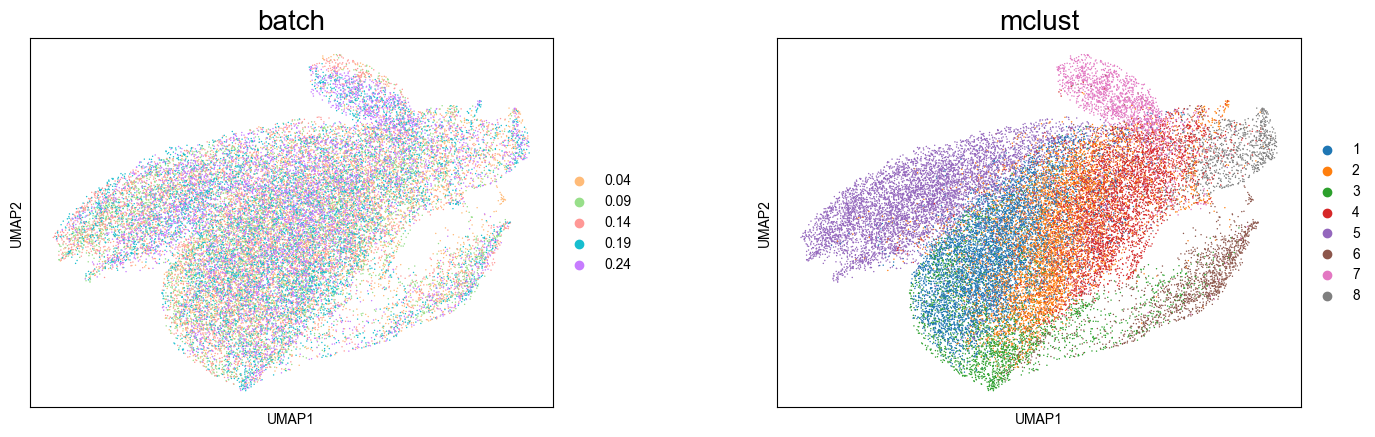

In [5]:
sc.pp.neighbors(adata_concat, use_rep='SIMPLE', random_state=seed)
sc.tl.umap(adata_concat, random_state=seed)

color = ['#ffbb78', '#98df8a', '#ff9896','#17becf','#c77cff']
color_dict = dict(zip(slice_ids, color))
adata_concat.uns['batch_colors'] = [color_dict[x] for x in adata_concat.obs.batch.cat.categories]
axs=sc.pl.umap(adata_concat, color=['batch', 'mclust'], ncols=2,wspace=0.3, show=False)
for ax in axs:
    ax.set_title(ax.get_title(),fontsize=20)
plt.show()
plt.close()

## 6. visualization

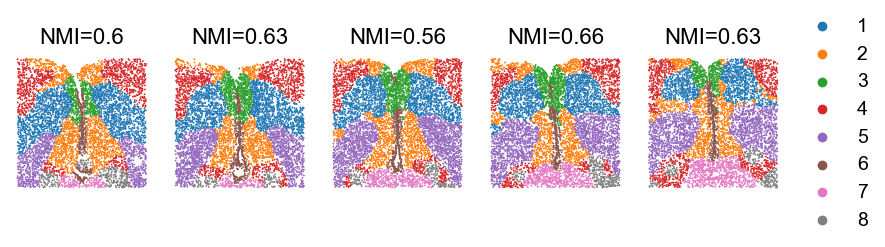

In [6]:
adata_list = []
NMI_list=[]
for i,id in enumerate(slice_ids):
    adata_list.append(adata_concat[adata_concat.obs['batch'] == id])
    NMI_list.append(round(nmi(adata_list[i].obs['ground_truth'], adata_list[i].obs['mclust']),2))

spot_size = 25
title_size = 16
fig, ax = plt.subplots(1, len(slice_ids), figsize=(10, 5), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
for i in range(len(slice_ids)):
    if i ==len(slice_ids)-1:
        _sc=sc.pl.spatial(adata_list[i], img_key=None, color=['mclust'], title=[''],legend_fontsize=14, show=False, ax=ax[i], frameon=False,spot_size=spot_size)
    else:
        _sc=sc.pl.spatial(adata_list[i], img_key=None, color=['mclust'], title=[''],legend_loc=None, legend_fontsize=14, show=False, ax=ax[i], frameon=False,spot_size=spot_size)
    _sc[0].set_title("NMI=" + str(NMI_list[i]), size=title_size)
plt.show()